# Entropy as a Predictor for Intraday Volatility in FX

We consider entropy as an estimator of intraday volatility. 'True' volatility is calculated as the 15 minute returns standard deviation across the day, whilst entropy is calculated using the same data - where we aim to estimate the volatility for the following day. This is done as opposed to estimates based on a rolling window.

Various entropy measures and predictive relationships are explored between entropy and volatility. We consider a GARCH + entropy measurement, linear regression, then non linear estimates based on decision trees, gradient boosting trees and finally some neural networks.

Given the volatility is not actually observed, we also apply our best estimator within a Kalman filter to attempt to form better estimates.

We initially use EURUSD data, then extend to other currency pairs. We begin working on low frequency data, looking later at higher frequency data.
As an extension, we use mutual information as a way to estimate currency pair correlation, and hence the 'driving currency' of volatility.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

In [9]:
path = 'C:/Users/camer/OneDrive/Documents/dev/home_research/data/volatility_entropy_project_fx/'

In [17]:
eurusd_data = pd.read_csv(path + 'EURUSD-2000-2020-15m.csv')[['DATE_TIME', 'CLOSE']]
eurusd_data

,DATE_TIME,CLOSE
0,2000.01.03 00:00:00,1.00770
1,2000.01.03 00:15:00,1.00860
2,2000.01.03 00:30:00,1.00790
3,2000.01.03 00:45:00,1.01280
4,2000.01.03 01:00:00,1.01220
...,...,...
500746,2020.03.19 05:00:00,1.08895
500747,2020.03.19 05:15:00,1.08872
500748,2020.03.19 05:30:00,1.09086
500749,2020.03.19 05:45:00,1.08970


In [18]:
from helper_functions.afml_functions.afml_modelling_lib import shannon_entropy

In [22]:
eurusd_data['ret'] = np.log(eurusd_data['CLOSE']/eurusd_data['CLOSE'].shift())
eurusd_data['date'] = pd.to_datetime(eurusd_data['DATE_TIME']).dt.date

In [32]:
eurusd_data['ret'].mean()

1.5613786810865325e-07

In [34]:
daily_vol_eurusd = eurusd_data[['date', 'ret']].groupby('date').std().rename({'ret': 'vol'}, axis=1)**2

<Axes: xlabel='date'>

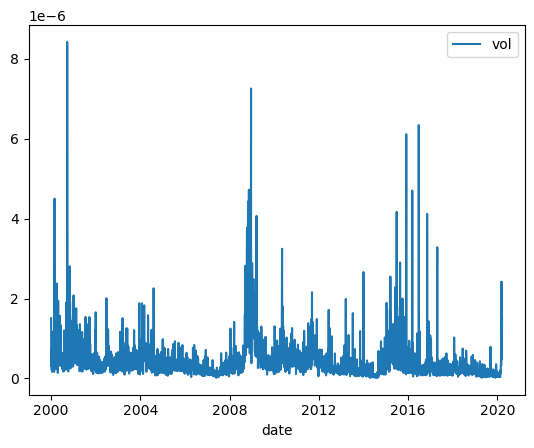

In [35]:
daily_vol_eurusd.plot()

<Axes: xlabel='date'>

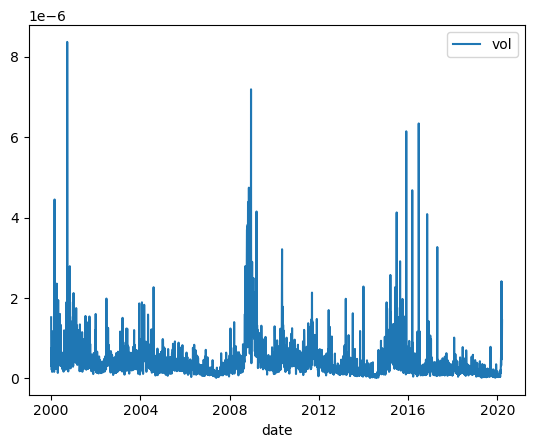

In [39]:
eurusd_data['ret_sqd'] = eurusd_data['ret']**2
eurusd_data[['date', 'ret_sqd']].groupby('date').mean().rename({'ret_sqd': 'vol'}, axis=1).plot()